In [12]:
import pandas as pd
import xarray as xr
import zipfile
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

p1 = os.getcwd()
p1

'/home/receiver/Desktop/Data/CMIP6'

In [13]:
#station = ['Talensi', 10.66, -0.72]
'''
#'cesm2_waccm_fv2','ec_earth3_cc','mpi_esm1_2_hr',

models = ['access_cm2','bcc_csm2_mr','cesm2_fv2','cmcc_cm2_hr4','cmcc_esm2','cnrm_cm6_1_hr',
'ec_earth3_aerchem','fgoals_f3_l','hadgem3_gc31_ll','iitm_esm','inm_cm5_0','ipsl_cm6a_lr','kiost_esm','miroc6',
'miroc_es2l','mri_esm2_0','norcpm1','noresm2_mm','taiesm1',
'access_esm1_5','awi_esm_1_1_lr','bcc_esm1','canesm5','cesm2','cesm2_waccm','cmcc_cm2_sr5',
'cnrm_cm6_1','cnrm_esm2_1','ec_earth3_veg_lr','fgoals_g3','gfdl_esm4','hadgem3_gc31_mm','inm_cm4_8',
'ipsl_cm5a2_inca','kace_1_0_g','mpi_esm1_2_lr','nesm3','sam0_unicon','ukesm1_0_ll']

models = sorted(models)



#Hist, SSP[2.6, 4.5, 6.0, 8.5]    #(W/m^2) GHG Forcing
'''

models = ['access_cm2','bcc_csm2_mr','cesm2','cmcc_esm2','cnrm_cm6_1','cnrm_esm2_1','ec_earth3_veg_lr','fgoals_g3',
          'gfdl_esm4','hadgem3_gc31_ll','iitm_esm','inm_cm4_8','inm_cm5_0','ipsl_cm5a2_inca','ipsl_cm6a_lr','kace_1_0_g', 
          'miroc6','mpi_esm1_2_lr','miroc_es2l','mri_esm2_0','noresm2_mm','taiesm1','ukesm1_0_ll']
#'sam0_unicon',
models = sorted(models)

In [3]:
#function to calculate the rainfall anomaly index
def rai(ds, dimension, method='ordinary'):
    ds_ma = ds.mean(dimension)
    
    ds_anom = ds - ds_ma
    
    if method.lower() == 'percentile':
        l_thresh = ds.reduce(np.nanpercentile,q=10,dim=dimension)
        u_thresh = ds.reduce(np.nanpercentile,q=90,dim=dimension)
        ds_low_10 = ds.where(ds<l_thresh).mean(dimension)
        ds_high_10 = ds.where(ds>u_thresh).mean(dimension)
    elif method.lower() == 'ordinary':
        thresh = ds.reduce(np.sort,dim=dimension)
        ds_low_10 = thresh[:10].mean(dimension)
        ds_high_10 = thresh[:-10:-1].mean(dimension)
    else:
        print('Wrong/No method selected.')
    
    
    negatives = -3*( (ds_anom.where(ds_anom<0)) / (ds_low_10-ds_ma) )
    positives = 3*( (ds_anom.where(ds_anom>0)) / (ds_high_10-ds_ma) )
    RAI = ds_anom.where(ds_anom>=0, negatives).where(ds_anom<0, positives)
    
    return RAI

In [4]:
#function to group RAI values between x and y and find their count
def filtercounter(ds, x, y):
    return ds.where((ds > x) & (ds <= y)).count().values.tolist()

#function to group RAI values between x and y and calculate their average values
def filtermean(ds, x, y):
    return ds.where((ds > x) & (ds <= y)).reduce(np.nanmean).values.tolist()


In [5]:
def count_avg_perc(ws):
    grouped_da_RAI = ws
    for class_name in classification:
        if (class_name == 'Extremely Dry'):
            n = grouped_da_RAI.where((grouped_da_RAI <= -3)).count().values.tolist()
            n2 = grouped_da_RAI.where((grouped_da_RAI <= -3)).reduce(np.nanmean).values.tolist()
            count_val.append(n)
            avg_val.append(n2)

        elif( class_name == 'Very Dry'):
            n = filtercounter(grouped_da_RAI,-3,-2)
            n2 = filtermean(grouped_da_RAI,-3,-2)
            count_val.append(n)
            avg_val.append(n2)

        elif(class_name == 'Dry'):
            n = filtercounter(grouped_da_RAI,-2,-1)
            n2 = filtermean(grouped_da_RAI,-2,-1)
            count_val.append(n)
            avg_val.append(n2)

        elif(class_name == 'Normal'):
            n = grouped_da_RAI.where((grouped_da_RAI >-1) & (grouped_da_RAI< 1)).count().values.tolist()
            count_val.append(n)
            n2 = grouped_da_RAI.where((grouped_da_RAI > -1) & (grouped_da_RAI< 1)).reduce(np.nanmean).values.tolist()
            avg_val.append(n2)

        elif(class_name == 'Humid'):
            n = filtercounter(grouped_da_RAI,1,2)
            count_val.append(n)
            n2 = filtermean(grouped_da_RAI,1,2)
            avg_val.append(n2)

        elif(class_name == 'Very Humid'):
            n = filtercounter(grouped_da_RAI,2,3)
            count_val.append(n)
            n2 = filtermean(grouped_da_RAI,2,3)
            avg_val.append(n2)

        else:
            n =grouped_da_RAI.where((grouped_da_RAI >= 3)).count().values.tolist()
            count_val.append(n)
            n2 = grouped_da_RAI.where((grouped_da_RAI >= 3)).reduce(np.nanmean).values.tolist()
            avg_val.append(n2)


    final_count[zone] = count_val
    f_count = pd.DataFrame(final_count).T
    f_count.columns=classification
    final_avg[zone] = avg_val
    f_avg = pd.DataFrame(final_avg).T
    f_avg.columns=classification
    return f_count, f_avg 

In [6]:
def background(ax,x):
    dx = 50
    theta = np.linspace(0,np.pi,100)#*100
    r = np.sin(theta)*(100-dx)

    #ax = plt.subplot(2,2,(o+1), polar=True)
    #ax = x.plot(polar=True)
    c = ax.scatter(theta, r, c=r, s=20, cmap='Blues', alpha=0.0)

    ax.set_thetamin(0)
    ax.set_thetamax(180)

    ax.set_yticks(np.arange(0,60.1,10),)#np.arange(-50,100.1,10))
    ax.text( -0.35, 40, 'Events (%)', color='k', fontsize = 15)
    ax.set_xticks(np.arange(0,np.pi+0.1,np.pi/8))

    perc = ['< -3', '-3', '-2', '-1', '', '1', '2', '3', '> 3']
    ax.set_xticklabels(perc[::-1])
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

    #Descriptors
    ax.text( 1.65, 116-dx, 'Normal', color='r', fontsize = 15)
    ax.text( 2.2, 117-dx, 'Dry', color='r', fontsize = 14, rotation=35)
    ax.text( 2.65, 117-dx, 'Very Dry', color='r', fontsize = 14, rotation=60)
    ax.text( 3.075, 120-dx, "Extremely\n Dry", color='r', fontsize = 14, rotation=82.5)

    ax.text( 1, 114-dx, 'Wet', color='r', fontsize = 14, rotation=-35)
    ax.text( 0.57, 108-dx, 'Very Wet', color='r', fontsize = 14, rotation=-60)
    ax.text( 0.03, 108-dx, "Extremely\n Wet", color='r', fontsize = 14, rotation=-82.5)


    ax.tick_params(axis='both', labelsize=12)
    ax.spines['inner'].set_color('r')
    ax.spines['polar'].set_linewidth(2)
    #ax.spines['end'].set_linewidth(0)

    ax.grid(True, which='major', axis='both', linestyle='--', color = 'b', linewidth=1)
    ax.get_xgridlines()[4].set_linestyle('None')
    ax.get_xgridlines()[-1].set_linestyle('None')
    ax.set_title(x, fontsize = 15)
    colors=['r']

    return ax


In [7]:
def pointers(ax, num, percentage, linestyle = None, color = None, marker=None, marksize=None, label=None, show_legend=None):
    b=num
    pos=np.int_(b)+(np.ones(len(b))*4)
    #pos = int(b)+4  #position of the whole number component of the number within the perc array.
    perc = ['< -3', '-3', '-2', '-1', '', '1', '2', '3', '> 3']
    whole = (((pos)/(len(perc)-1))*np.pi)       #change whole part to angle
    bot = np.ones(len(b))*(len(perc)-1)
    bot1 = np.ones(len(b))*np.pi
    frac = ((b-np.int_(b))/bot)*bot1    #change fractional part to angle

    if color == None:
        ax.plot(np.pi-whole-frac,percentage,linestyle=linestyle, linewidth=2, marker = marker, markersize=marksize, label=label)
    else:
        ax.plot(np.pi-whole-frac,percentage,linestyle=linestyle, color=color, linewidth=5, marker = marker, markersize=marksize, label=label)
   
    #ax.legend(loc=0, ncol=3, bbox_to_anchor=(1.25, 1))

    if show_legend==True:
        ax.legend(loc=0, ncol=2, bbox_to_anchor=(2.6, 0.8), fontsize=14)
    #else:
    #    ax.legend(loc=0, ncol=10, bbox_to_anchor=(1.25, 1), alpha=0.0)


### Polar plots of RAI percentages of rainfall events for the ecological zones over West Africa

In [8]:
def save_plot(path, filename):
    import matplotlib.pyplot as plt
    if os.path.isdir(path) == False:
        os.mkdir(path)
        
    plt.savefig(path+'/'+filename)

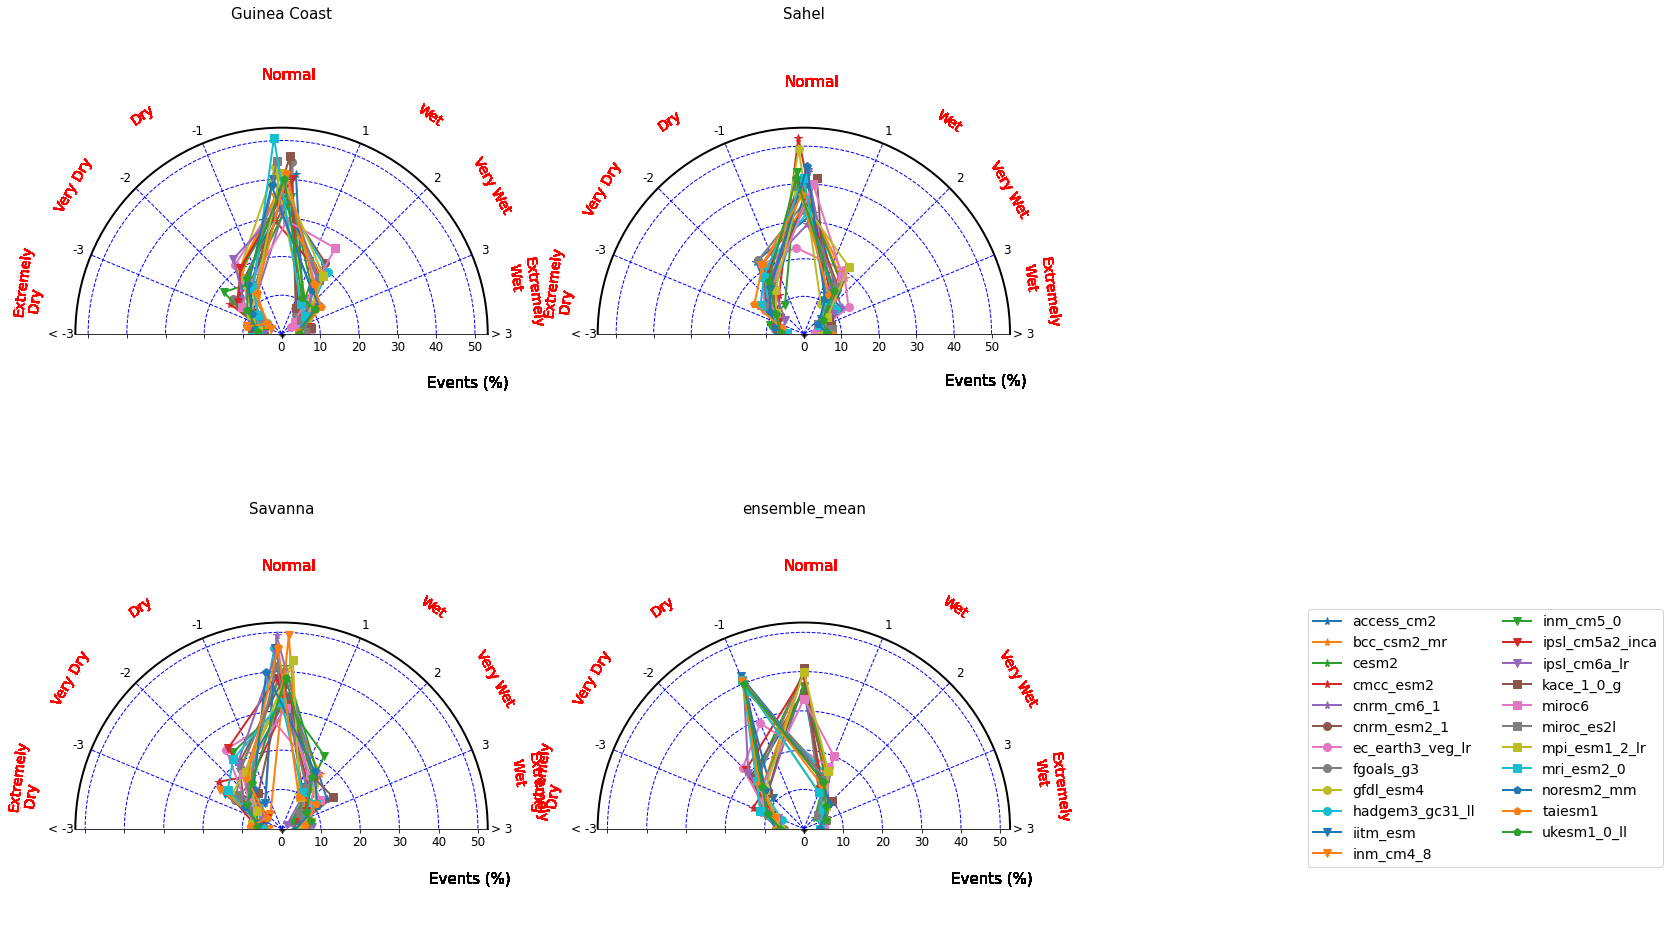

In [14]:
exp='historical'
ystart=1950; yend=2014
classification = ['Extremely Dry', 'Very Dry', 'Dry','Normal', 'Humid', 'Very Humid', 'Extremely Wet']

#plt.figure(figsize = (14,14))

#plt.subplots_adjust(hspace=0.5) 
fig,axes = plt.subplots(2,2,figsize = (14,14),subplot_kw=dict(polar=True))
#plt.subplots_adjust(hspace=0.5)
fig.subplots_adjust(top=0.9, left=0,right=0.95, bottom=0) 
ax = axes.flatten()
zones = ['Guinea Coast','Sahel','Savanna', 'ensemble_mean']
for i, mod in enumerate(models):
    file = glob.glob(os.path.join(p1,exp+'/*'+mod+'*.zip'))[0]
    data_file = glob.glob(os.path.join(p1,mod+'/pr*'+exp+'*.nc'))[0]
    da_data = xr.open_dataset(data_file)
    
    
    percentages={}
    for j,zone in enumerate(zones):
        a = background(ax[j],zone)
        final_count = {}
        final_avg = {}
        count_val = []
        avg_val = []

        if zone == 'Guinea Coast':
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(4,8), time=slice(str(ystart),str(yend))).mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            a2 = da_RR.resample(time='1Y').sum('time')
            b = rai(a2, 'time','ordinary')
            C,AV = count_avg_perc(b)
            per = (C/max(C.sum(axis = 1)))*100
            #ax[i].bar(['time.year'], stand(a, 'time').values, color=col_scheme)#, ax=rows)
            markers = ['*','o','v','s','p']
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=False)
            av_GC = AV.iloc[0,:] ; per_GC = per.iloc[0,:]
            
            #print(av_GC, per_GC)
            
        elif zone == 'Sahel':
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(12,20), time=slice(str(ystart),str(yend))).mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            a1 = da_RR.resample(time='1Y').sum('time')
            b = rai(a1, 'time','ordinary')
            C,AV = count_avg_perc(b)
            per = (C/max(C.sum(axis = 1)))*100
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=False)
            av_Sh = AV.iloc[0,:] ; per_Sh = per.iloc[0,:]
        elif zone == 'Savanna':
            s = da_data.pr.sel(lon=slice(-17,17), lat=slice(8,12), time=slice(str(ystart),str(yend))).mean(['lon','lat'])
            da_RR = s* 86400   #convert rainfall from kg m-2 s-1 to mm/day
            a2 = da_RR.resample(time='1Y').sum('time')
            b = rai(a2, 'time','ordinary')
            C,AV = count_avg_perc(b)
            per = (C/max(C.sum(axis = 1)))*100
            markers = ['*','o','v','s','p']
            pointers(a, AV.iloc[0,:], per.iloc[0,:], color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=False)
            av_Sv = AV.iloc[0,:] ; per_Sv = per.iloc[0,:]
        else:
            markers = ['*','o','v','s','p']
            pointers(a,(av_GC + av_Sh + av_Sv)//3 , (per_GC + per_Sh + per_Sv)//3, color=None, 
             linestyle = '-', marker = markers[i//5], marksize=8, label=mod, show_legend=True)
            
#fig.delaxes(ax[3])           
   
#save_plot('/home/receiver/Desktop/Data/plots/','Polar_plot_extreme_events')

In [38]:
#(av_GC + av_Sh + av_Sv)//3

#np.nanmean([av_GC,av_Sh])
#np.nanmean(av_Sh)
#np.nanmean(av_Sv)

In [30]:
AV.iloc[0,:]

Extremely Dry   -3.783297
Very Dry        -2.432993
Dry             -1.482049
Normal           0.070950
Humid            1.366914
Very Humid       2.468788
Extremely Wet    3.359733
Name: Savanna, dtype: float64

In [34]:
n_AV = { 'Extremely Dry':av_GC.values, 
        'Very Dry':av_GC.values,
        'Dry':av_GC.values,
        'Normal':av_GC.values,
        'Humid':av_GC.values,
        'Very Humid':av_GC.values,
        'Extremely Wet':av_GC.values,
       }

ensemble = pd.DataFrame(n_AV)
ensemble

,Extremely Dry,Very Dry,Dry,Normal,Humid,Very Humid,Extremely Wet
0,-3.787319,-3.787319,-3.787319,-3.787319,-3.787319,-3.787319,-3.787319
1,-2.442105,-2.442105,-2.442105,-2.442105,-2.442105,-2.442105,-2.442105
2,-1.411965,-1.411965,-1.411965,-1.411965,-1.411965,-1.411965,-1.411965
3,0.045735,0.045735,0.045735,0.045735,0.045735,0.045735,0.045735
4,1.299460,1.299460,1.299460,1.299460,1.299460,1.299460,1.299460
5,2.406631,2.406631,2.406631,2.406631,2.406631,2.406631,2.406631
6,4.053238,4.053238,4.053238,4.053238,4.053238,4.053238,4.053238
